# Draft For Orbits Deep Learning

In [14]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

In [15]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

In [16]:
train_path= "orbit_final_dataset/train/orbit_images"
test_path="orbit_final_dataset/test/orbit_images"
val_path="orbit_final_dataset/val/orbit_images"

In [17]:
x_train=[]

for folder in os.listdir(train_path):
    sub_path=train_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))

        x_train.append(img_arr)

In [18]:
x_test=[]

for folder in os.listdir(test_path):
    sub_path=test_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_test.append(img_arr)
    

In [19]:
x_val=[]

for folder in os.listdir(val_path):
    sub_path=val_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        
        x_val.append(img_arr)
    

In [20]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

In [21]:
train_x.shape,test_x.shape,val_x.shape

((460, 224, 224, 3), (91, 224, 224, 3), (33, 224, 224, 3))

In [22]:
train_x=train_x/255.0
test_x= test_x/255.0 
val_x=val_x/255.0

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [24]:
# train_datagen = ImageDataGenerator(rescale = 1./255,
#                                    shear_range = 0.2,
#                                    zoom_range = 0.2,
#                                    horizontal_flip = True)

train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)


training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 460 images belonging to 5 classes.
Found 91 images belonging to 1 classes.
Found 33 images belonging to 3 classes.


In [25]:
training_set.class_indices

{'EtaAquaridsMeteorShower': 0,
 'LeonidsMeteorShower': 1,
 'LyridsMeteorShower': 2,
 'OrionidsMeteorShower': 3,
 'PerseidsMeteorShower': 4}

In [26]:
train_y=training_set.classes


In [27]:
test_y=test_set.classes


In [28]:
val_y=val_set.classes

In [29]:
train_y.shape,test_y.shape,val_y.shape

((460,), (91,), (33,))

In [30]:
# add preprocessing layer to the front of VGG
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [31]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [32]:
# our layers - add more if you want
x = Flatten()(vgg.output)

prediction = Dense(7, activation='softmax')(x)

In [33]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [34]:
# tell the model what cost and optimization method to use
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
  
)


In [35]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

#Early stopping to avoid overfitting of model

In [36]:
# fit the model
# run this cell need around 13 minutes
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=10,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

Epoch 1/10
15/15 [==============================] - 71s 5s/step - loss: 2.5193 - accuracy: 0.2391 - val_loss: 1.3926 - val_accuracy: 0.3333
Epoch 2/10
15/15 [==============================] - 75s 5s/step - loss: 1.4886 - accuracy: 0.4304 - val_loss: 0.9046 - val_accuracy: 0.8485
Epoch 3/10
15/15 [==============================] - 75s 5s/step - loss: 1.0899 - accuracy: 0.6435 - val_loss: 1.4543 - val_accuracy: 0.0000e+00
Epoch 4/10
15/15 [==============================] - 73s 5s/step - loss: 0.9007 - accuracy: 0.6478 - val_loss: 1.3268 - val_accuracy: 0.3939
Epoch 5/10
15/15 [==============================] - 72s 5s/step - loss: 0.8808 - accuracy: 0.7304 - val_loss: 0.9092 - val_accuracy: 0.3939
Epoch 6/10
15/15 [==============================] - 72s 5s/step - loss: 0.6876 - accuracy: 0.7978 - val_loss: 0.8456 - val_accuracy: 0.7879
Epoch 7/10
15/15 [==============================] - 75s 5s/step - loss: 0.5411 - accuracy: 0.9261 - val_loss: 0.8094 - val_accuracy: 0.9697
Epoch 8/10
15/15

In [37]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


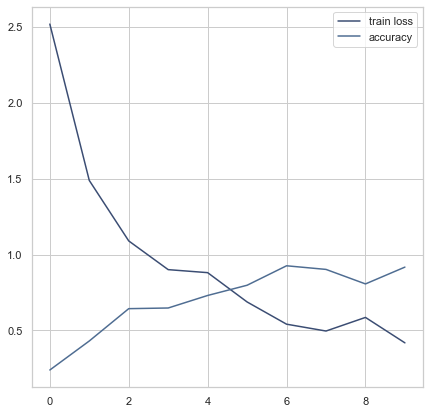

In [38]:
# loss
import seaborn as sns
sns.set(rc = {'figure.figsize':(7,7)})
sns.set_theme(style="whitegrid", palette="ch:r=-.2,d=.3_r")

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['accuracy'], label='accuracy')    #try val_loss and val_accuracy when the dataset is bigger
plt.legend()

plt.savefig('vgg-loss-rps-1.png')
plt.show()

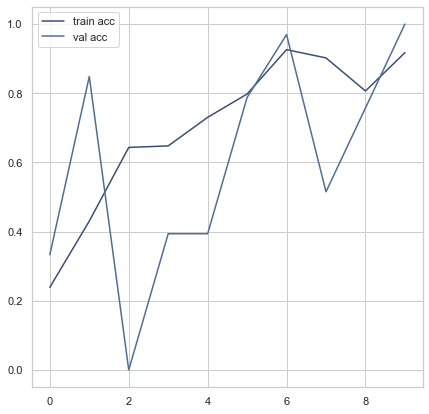

In [39]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()

plt.savefig('vgg-acc-rps-1.png')
plt.show()

In [40]:
#run this cell need around 1.5 minutes



model.evaluate(train_x,train_y,batch_size=32)

15/15 [==============================] - 66s 4s/step - loss: 0.4338 - accuracy: 0.9174


[0.43377748131752014, 0.917391300201416]

In [44]:
model.evaluate(test_x,test_y,batch_size=32)

3/3 [==============================] - 13s 4s/step - loss: 0.1873 - accuracy: 0.9890


[0.1872861683368683, 0.9890109896659851]

In [45]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

In [46]:
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

In [47]:
accuracy_score(y_pred,test_y)

0.989010989010989

In [48]:
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        90
           1       0.00      0.00      0.00         1

    accuracy                           0.99        91
   macro avg       0.49      0.50      0.50        91
weighted avg       0.98      0.99      0.98        91



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
confusion_matrix(y_pred,test_y)

array([[90,  0],
       [ 1,  0]], dtype=int64)

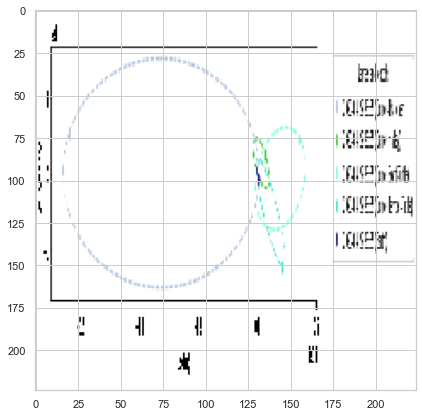

PerseidsMeteorShower


In [50]:
path= "orbit_final_dataset/results"
for img in os.listdir(path):
    img=image.load_img(path+"/"+img, target_size=(224,224))
    plt.imshow(img)
    plt.show()
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    images=np.vstack([x])
    pred=model.predict(images,batch_size=1) 
    
    if pred[0][0]>= 0.5:
        print("PerseidsMeteorShower")
    elif pred[0][1]>= 0.5:
        print("EtaAquaridsMeteorShower")
    elif pred[0][2]>= 0.5:
        print("LeonidsMeteorShower")
    elif pred[0][3]>= 0.5:
        print("LyridsMeteorShower")
    elif pred[0][4]>= 0.5:
        print("OrionidsMeteorShower")

    else:
        print("Unknown")